# Загрузка Pandas и очистка данных

In [27]:
import pandas as pd
import numpy as np
import re
import statistics
import matplotlib.pyplot as plt
import seaborn as sns
from geopy.geocoders import Nominatim
%matplotlib inline

In [2]:
df = pd.read_csv('main_task.csv', low_memory=False)
df.columns = ['restaurant_id', 'city', 'cuisine_style', 'ranking', 'rating',
              'price_range', 'number_of_reviews', 'reviews', 'url_ta', 'id_ta']
df.head()

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta
0,id_5569,Paris,"['European', 'French', 'International']",5570.0,3.5,$$ - $$$,194.0,"[['Good food at your doorstep', 'A good hotel ...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643
1,id_1535,Stockholm,NaN,1537.0,4.0,NaN,10.0,"[['Unique cuisine', 'Delicious Nepalese food']...",/Restaurant_Review-g189852-d7992032-Reviews-Bu...,d7992032
2,id_352,London,"['Japanese', 'Sushi', 'Asian', 'Grill', 'Veget...",353.0,4.5,$$$$,688.0,"[['Catch up with friends', 'Not exceptional'],...",/Restaurant_Review-g186338-d8632781-Reviews-RO...,d8632781
3,id_3456,Berlin,NaN,3458.0,5.0,NaN,3.0,"[[], []]",/Restaurant_Review-g187323-d1358776-Reviews-Es...,d1358776
4,id_615,Munich,"['German', 'Central European', 'Vegetarian Fri...",621.0,4.0,$$ - $$$,84.0,"[['Best place to try a Bavarian food', 'Nice b...",/Restaurant_Review-g187309-d6864963-Reviews-Au...,d6864963


## Предобработка

In [31]:
def clean_name(str_val):
    """
    Преобразует строку с названиями в список [list] названий.
    На входе:
        - строковая переменная, содержащая названия.
    На выходе:
        - список [list] названий.
    """
    if pd.isna(str_val):
        return ["unknown"]
    str_val = str_val.strip('[]')  # Отбрасываем скобки.
    str_val = str_val.replace("\'", '')  # Убираем кавычки '.
    str_val = str_val.split(", ")  # Разбиваем строку по названиям.
    return str_val


geolocator = Nominatim(user_agent="Google")


def country(city):
    """
    С помощью библиотеки geopy определяется геолокация города 
    по нему определяется страна 
    """
    location = geolocator.geocode(
        city, exactly_one=True, addressdetails=True, language='en')
    address = location.raw['address']
    country = address.get('country', '')
    return country


def get_boxplot(column):
    fig, ax = plt.subplots(figsize=(10, 4))
    sns.boxplot(x=column, y='rating',
                data=df.loc[df.loc[:, column].isin(
                    df.loc[:, column].value_counts().index[:40])],
                ax=ax)
    plt.xticks(rotation=45)
    ax.set_title('Boxplot for ' + column)
    plt.show()

In [4]:
df.info()
print('Столбцов с нулевыми значениями:', len(df.columns[df.isna().any()]))
display(df.isna().sum())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 40000 entries, 0 to 39999
Data columns (total 10 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   restaurant_id      40000 non-null  object 
 1   city               40000 non-null  object 
 2   cuisine_style      30717 non-null  object 
 3   ranking            40000 non-null  float64
 4   rating             40000 non-null  float64
 5   price_range        26114 non-null  object 
 6   number_of_reviews  37457 non-null  float64
 7   reviews            40000 non-null  object 
 8   url_ta             40000 non-null  object 
 9   id_ta              40000 non-null  object 
dtypes: float64(3), object(7)
memory usage: 3.1+ MB
Столбцов с нулевыми значениями: 3


restaurant_id            0
city                     0
cuisine_style         9283
ranking                  0
rating                   0
price_range          13886
number_of_reviews     2543
reviews                  0
url_ta                   0
id_ta                    0
dtype: int64

In [5]:
df['price_range'].unique()

array(['$$ - $$$', nan, '$$$$', '$'], dtype=object)

In [6]:
df.restaurant_id[df['price_range'] == '$$ - $$$'].count()

18412

In [7]:
df.city.nunique()

31

In [8]:
# очищаем и разбиваем списки кухонь поэлементно
df['cuisine_style'] = df['cuisine_style'].apply(clean_name)
df = df.explode('cuisine_style')

In [9]:
df['cuisine_style'].nunique()-1

125

In [10]:
df['cuisine_style'].value_counts()

Vegetarian Friendly    11189
European               10060
unknown                 9283
Mediterranean           6277
Italian                 5964
                       ...  
Latvian                    1
Salvadoran                 1
Burmese                    1
Yunnan                     1
Xinjiang                   1
Name: cuisine_style, Length: 126, dtype: int64

In [11]:
data = pd.read_csv('main_task.csv')
data['Cuisine Style'] = data['Cuisine Style'].apply(clean_name)
round(data['Cuisine Style'].apply(lambda x: len(x)).mean(), 1)

2.6

In [12]:
data = df.copy()
pattern = re.compile('\'\d+\/\d+\/\d+\'')
data['rev_date'] = df['reviews'].apply(pattern.findall)
data['rev_date'] = data['rev_date'].apply(lambda x: [x[-2], x[-1]] if len(x) >= 3
                                          else x)
data['rev_1'] = data['rev_date'].apply(lambda x: x[0] if len(x) >= 1 else None)
data['rev_2'] = data['rev_date'].apply(lambda x: x[1] if len(x) == 2 else None)

data['rev_1'] = pd.to_datetime(data['rev_1'])
data['rev_2'] = pd.to_datetime(data['rev_2'])
# добавляем новый признак разница в днях между отзывами
df['day_rev'] = abs(data['rev_1'] - data['rev_2'])
# преобразуем к нужному формату из timedelta
df['day_rev'] = df['day_rev'].apply(lambda x: float(x.days))
delta = abs(data['rev_1'] - data['rev_2']).max()
delta

Timedelta('3207 days 00:00:00')

In [13]:
template = re.compile('\'\d+\/\d+\/\d+\'')
df['reviews_date'] = df['reviews'].apply(template.findall)
df = df.explode('reviews_date')
df['reviews_date'] = pd.to_datetime(df['reviews_date'])
max_date = df['reviews_date'].max()
print(max_date)

2018-02-26 00:00:00


In [14]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193660 entries, 0 to 39999
Data columns (total 12 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   restaurant_id      193660 non-null  object        
 1   city               193660 non-null  object        
 2   cuisine_style      193660 non-null  object        
 3   ranking            193660 non-null  float64       
 4   rating             193660 non-null  float64       
 5   price_range        170011 non-null  object        
 6   number_of_reviews  190101 non-null  float64       
 7   reviews            193660 non-null  object        
 8   url_ta             193660 non-null  object        
 9   id_ta              193660 non-null  object        
 10  day_rev            177528 non-null  float64       
 11  reviews_date       184350 non-null  datetime64[ns]
dtypes: datetime64[ns](1), float64(4), object(7)
memory usage: 19.2+ MB


In [15]:
# преображаем в числовой тип
df['price_range'] = df['price_range'].apply(lambda x: float(1) if x == '$' else
                                            float(2) if x == '$$ - $$$' else
                                            float(3) if x == '$$$$' else None)

In [16]:
# заполняем модой пропуски
df['price_range'] = df['price_range'].fillna(statistics.mode(df.price_range))

In [17]:
df['number_of_reviews'] = df['number_of_reviews'].fillna(
    df['number_of_reviews'].median())

In [18]:
df['reviews'] = df['reviews'].apply(clean_name)
df.reviews = df.reviews.apply(lambda x: [x[0], x[1]] if len(x) >= 3
                              else x)

In [19]:
# Убираем лишнее из rest_id и преобразуем в integer
df['restaurant_id'] = df['restaurant_id'].apply(
    lambda x: int(x.replace('id_', '')))

In [20]:
"""
    Создается фрейм с соответсвием rest_id количеству id TripAdviser.
    Если одному rest_id соответсвует больше 1 id TA, значит ресторан сетевой = 1
    Если 1, то не сетевой = 0
    Создается новый признак в основном фрейме
"""
data2 = pd.DataFrame(df.groupby(['restaurant_id'])['id_ta'].nunique())
for i in data2.index:
    if data2.loc[i].id_ta > 1:
        df.loc[df['restaurant_id'] == i, 'chain_rest'] = 1
    else:
        df.loc[df['restaurant_id'] == i, 'chain_rest'] = 0

In [21]:
# заполняем пустые значения дней между отзывами самым частым значением
df['day_rev'] = df['day_rev'].fillna(statistics.mode(df.day_rev))

In [22]:
"""
чтобы ускорить проходку по всем городам и заполнение страны по городу
создаем список уникальных городов и если город в списке 
значит заполнение страны не требуется
"""

unique_cities = []
for town in df.city:
    if town not in unique_cities:
        unique_cities.append(town)
        df.loc[df['city'] == town, 'country'] = country(town)

In [23]:
# делаем переиндексацию dataframe перед добавлением dummy переменных
df.reset_index(drop=True)

,restaurant_id,city,cuisine_style,ranking,rating,price_range,number_of_reviews,reviews,url_ta,id_ta,day_rev,reviews_date,chain_rest,country
0,5569,Paris,European,5570.0,3.5,2.0,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,41.0,2017-12-31,1.0,France
1,5569,Paris,European,5570.0,3.5,2.0,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,41.0,2017-11-20,1.0,France
2,5569,Paris,French,5570.0,3.5,2.0,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,41.0,2017-12-31,1.0,France
3,5569,Paris,French,5570.0,3.5,2.0,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,41.0,2017-11-20,1.0,France
4,5569,Paris,International,5570.0,3.5,2.0,194.0,"[Good food at your doorstep, A good hotel rest...",/Restaurant_Review-g187147-d1912643-Reviews-R_...,d1912643,41.0,2017-12-31,1.0,France
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
193655,640,Warsaw,Central European,641.0,4.0,2.0,70.0,"[Underground restaurant, Oldest Restaurant in ...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,23.0,2017-06-18,1.0,Poland
193656,640,Warsaw,Vegetarian Friendly,641.0,4.0,2.0,70.0,"[Underground restaurant, Oldest Restaurant in ...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,23.0,2017-07-11,1.0,Poland
193657,640,Warsaw,Vegetarian Friendly,641.0,4.0,2.0,70.0,"[Underground restaurant, Oldest Restaurant in ...",/Restaurant_Review-g274856-d1100838-Reviews-Ho...,d1100838,23.0,2017-06-18,1.0,Poland
193658,4824,Milan,Spanish,4827.0,3.0,2.0,260.0,"[Average, Nice an informal]]",/Restaurant_Review-g187849-d1109020-Reviews-Ta...,d1109020,1306.0,2016-01-31,1.0,Italy


In [24]:
df.corr()

,restaurant_id,ranking,rating,price_range,number_of_reviews,day_rev,chain_rest
restaurant_id,1.000000,1.000000,-0.401200,-0.080341,-0.238215,0.125747,-0.679468
ranking,1.000000,1.000000,-0.401215,-0.080353,-0.238251,0.125718,-0.679458
rating,-0.401200,-0.401215,1.000000,-0.028866,0.035344,-0.112444,0.243752
price_range,-0.080341,-0.080353,-0.028866,1.000000,0.159871,-0.047734,0.036040
number_of_reviews,-0.238215,-0.238251,0.035344,0.159871,1.000000,-0.153694,0.112608
day_rev,0.125747,0.125718,-0.112444,-0.047734,-0.153694,1.000000,-0.069397
chain_rest,-0.679468,-0.679458,0.243752,0.036040,0.112608,-0.069397,1.000000


In [25]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 193660 entries, 0 to 39999
Data columns (total 14 columns):
 #   Column             Non-Null Count   Dtype         
---  ------             --------------   -----         
 0   restaurant_id      193660 non-null  int64         
 1   city               193660 non-null  object        
 2   cuisine_style      193660 non-null  object        
 3   ranking            193660 non-null  float64       
 4   rating             193660 non-null  float64       
 5   price_range        193660 non-null  float64       
 6   number_of_reviews  193660 non-null  float64       
 7   reviews            193660 non-null  object        
 8   url_ta             193660 non-null  object        
 9   id_ta              193660 non-null  object        
 10  day_rev            193660 non-null  float64       
 11  reviews_date       184350 non-null  datetime64[ns]
 12  chain_rest         193660 non-null  float64       
 13  country            193660 non-null  object   

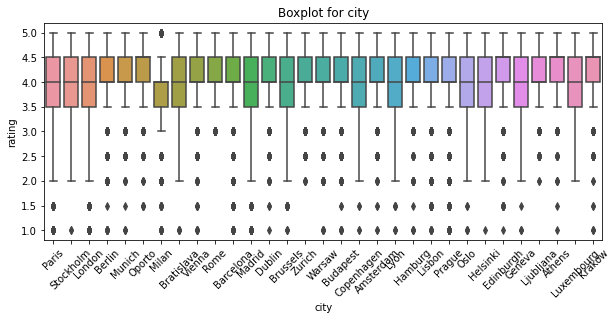

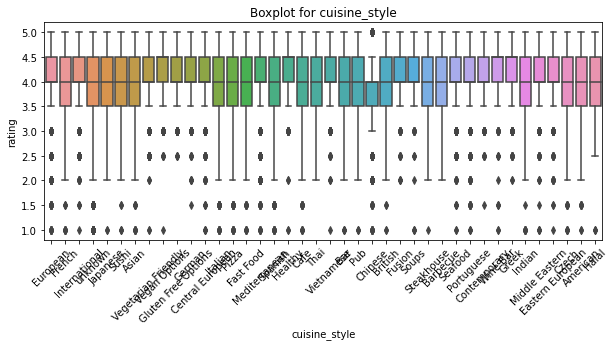

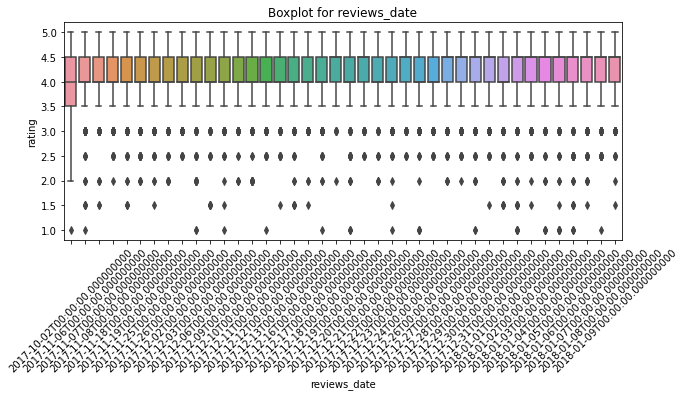

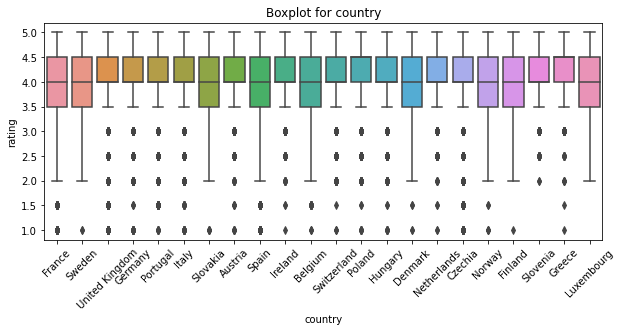

In [32]:
for col in ['city', 'cuisine_style', 'reviews_date', 'country']:
    get_boxplot(col)

In [33]:
# удаляем не интересные нам столбцы и столбец rest_id ввиду его полной корреляции с ranking
df = df.drop(['restaurant_id', 'reviews',
              'reviews_date', 'url_ta', 'id_ta'], axis=1)

# Создание dammy-переменных

In [34]:
df = pd.get_dummies(data=df, columns=['city', 'country', 'cuisine_style'])

# Разбиваем датафрейм на части, необходимые для обучения и тестирования модели

In [35]:
# Х - данные с информацией о ресторанах, у - целевая переменная (рейтинги ресторанов)
X = df.drop(['rating'], axis=1)
y = df['rating']

In [36]:
# Загружаем специальный инструмент для разбивки:
from sklearn.model_selection import train_test_split

In [37]:
# Наборы данных с меткой "train" будут использоваться для обучения модели, "test" - для тестирования.
# Для тестирования мы будем использовать 25% от исходного датасета.
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25)

# Создаём, обучаем и тестируем модель

In [38]:
# Импортируем необходимые библиотеки:
# инструмент для создания и обучения модели
from sklearn.ensemble import RandomForestRegressor
from sklearn import metrics  # инструменты для оценки точности модели

In [39]:
# Создаём модель
regr = RandomForestRegressor(n_estimators=100)

# Обучаем модель на тестовом наборе данных
regr.fit(X_train, y_train)

# Используем обученную модель для предсказания рейтинга ресторанов в тестовой выборке.
# Предсказанные значения записываем в переменную y_pred
y_pred = regr.predict(X_test)

In [40]:
# Сравниваем предсказанные значения (y_pred) с реальными (y_test), и смотрим насколько они в среднем отличаются
# Метрика называется Mean Absolute Error (MAE) и показывает среднее отклонение предсказанных значений от фактических.
print('MAE:', metrics.mean_absolute_error(y_test, y_pred))

MAE: 0.0413385314468656
